<a href="https://colab.research.google.com/github/eunbinni/novel/blob/main/%EC%86%8C%EC%84%A4_%EC%9E%91%EA%B0%80_%EB%B6%84%EB%A5%98_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **라이브러리 불러오기 / 데이터 살펴보기**

In [2]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM

In [3]:
#경로를 설정합니다.
import os
os.chdir('/content/drive/MyDrive/월간 09/Writing_Style/소설 작가 분류 AI 경진대회_data')

In [4]:
# pandas를 이용하여 파일을 불러옵니다. 
train = pd.read_csv('train.csv', encoding = 'utf-8')
test = pd.read_csv('test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('sample_submission.csv', encoding = 'utf-8')

In [5]:
train
#소설 작가들의 다양한 글들이 train data에 나타나있습니다.
# (54879, 3)의 shape를 볼 수 있습니다.

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


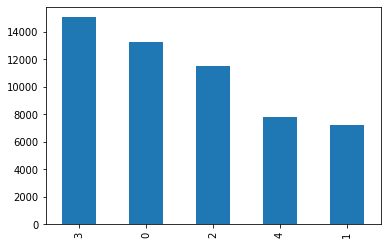

In [6]:
train['author'].value_counts().plot(kind='bar')
#train 데이터 살펴보기 : author은 0~4까지 총 5개인 것을 알 수 있습니다.

In [7]:
test
# 마찬가지로 소설 작가들의 다양한 글들이 test data에 나타나있고,
# (19617, 2)의 shape을 확인할 수 있습니다.

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [8]:
#sample_submission은 저장하여 대회에 제출할 때 사용합니다.
sample_submission

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


In [9]:
# 문장 길이 분포도 확인
train['doc_len'] = train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

NameError: ignored

# **Preprocessing**

In [11]:
# train data 전처리 : 대문자를 소문자로 변환하고, 부호를 제거합니다.
def alpha_num(text):
    return re.sub(r"[^a-zA-Z0-9]", " ", text)

def convert(text):
    return text.lower()

train['text']=train['text'].apply(alpha_num)
train['text']=train['text'].apply(convert)

* 대문자 소문자 변환, 부호제거가 된 것을 볼 수 있습니다. 

In [12]:
train

,index,text,author,doc_len
0,0,he was almost choking there was so much so m...,3,46
1,1,your sister asked for it i suppose,2,7
2,2,she was engaged one day as she walked in per...,1,57
3,3,the captain was in the porch keeping himself ...,4,58
4,4,have mercy gentlemen odin flung up his han...,3,39
...,...,...,...,...
54874,54874,is that you mr smith odin whispered i h...,2,15
54875,54875,i told my plan to the captain and between us ...,4,18
54876,54876,your sincere well wisher friend and sister...,1,8
54877,54877,then you wanted me to lend you money,3,8


In [13]:
# 불용어를 제거합니다.
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
          

In [14]:
train['text']=train['text'].apply(remove_stopwords)

* 불용어까지 제거가 된 것을 볼 수 있습니다.

In [15]:
train

,index,text,author,doc_len
0,0,almost choking much much wanted say strange ex...,3,46
1,1,sister asked suppose,2,7
2,2,engaged one day walked perusing jane s last le...,1,57
3,3,captain porch keeping carefully way treacherou...,4,58
4,4,mercy gentlemen odin flung hands don t write a...,3,39
...,...,...,...,...
54874,54874,mr smith odin whispered hardly dared hope come,2,15
54875,54875,told plan captain us settled details accomplis...,4,18
54876,54876,sincere well wisher friend sister lucy odin,1,8
54877,54877,wanted lend money,3,8


* test data도 똑같이 전처리를 해줍니다.

In [16]:
def alpha_num2(text):
    return re.sub(r"[^a-zA-Z0-9]", " ", text)
    
def convert2(text):
    return text.lower()

test['text']=test['text'].apply(alpha_num2)
test['text']=test['text'].apply(convert2)

def remove_stopwords2(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

train['text']=train['text'].apply(remove_stopwords2)

In [17]:
test

,index,text
0,0,not at all i think she is one of the most ch...
1,1,no replied he with sudden consciousness ...
2,2,as the lady had stated her intention of scream...
3,3,and then suddenly in the silence i heard a so...
4,4,his conviction remained unchanged so far as i...
...,...,...
19612,19612,at the end of another day or two odin growing...
19613,19613,all afternoon we sat together mostly in silen...
19614,19614,odin having carried his thanks to odin proc...
19615,19615,soon after this upon odin s leaving the room ...


* 위에서 한 전처리를 적용해줍니다.

In [26]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

# **Vectorization**

In [27]:
# 먼저 train 데이터와 test 데이터 인덱스 없이 배열로 만들어줍니다.
# train과 test를 분리해줍니다.

X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(54879,)
(19617,)
(54879,)


In [20]:
print(X_train)

['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity'
 'sister asked suppose'
 'engaged one day walked perusing jane s last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'
 ... 'sincere well wisher friend sister lucy odin' 'wanted lend money'
 'certainly not occurred said yes like']


In [21]:
print(X_test)

['not think one charming young ladies ever met might useful work decided genius way witness way preserved agra plan papers father love emotional thing whatever emotional opposed true cold reason place things never marry lest bias judgment'
 'no replied sudden consciousness not find cannot ignorant goodness owe feel express well know no orator'
 'lady stated intention screaming course screamed additional boldness exertion rendered unnecessary hasty knocking door no sooner heard mr odin darted much agility wine bottles began dusting great violence matron sharply demanded'
 ...
 'odin carried thanks odin proceeded happiness lucy excess time reached bartlett s buildings able assure mrs odin called next day congratulations never seen spirits life'
 'soon upon odin s leaving room mama said odin alarm subject illness cannot conceal sure odin not well now almost fortnight yet not come nothing real indisposition occasion extraordinary delay else can detain norland'
 'worse doomed man denouncer 

In [22]:
print(y_train)

[3 2 1 ... 1 3 0]


* parameter를 설정해줍니다.


In [30]:
vocab_size = 20000 
embedding_dim = 64        #feature, 한 단어 각각 vector의 원소 개수를 의미합니다.
max_length = 200
padding_type='post'

* fit_on_text()를 사용하여 벡터화를 합니다. data를 받아서 리스트의 형태로 변환하는 함수입니다.
* word_index()는 단어와 숫자의 key-value 쌍을 포함하는 딕셔너리를 반환합니다. 이때 반환 시 자동으로 소문자로 변환되어 들어갑니다.

In [31]:
# text를 token(사용할 단위)으로 분할하는 작업을 해줍니다. : tokenizing 

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

* texts_to_sequences()는 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환합니다.

* 변환한 것의 길이가 일정하지 않기 때문에 (최대 길이 214) pad_sequences()를 이용하여 0을 넣어 같은 길이의 sequence로 변환합니다.

In [32]:
#데이터를 sequence로 변환해주고 padding합니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length) 

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

- pre-trained word2vec를 통해서 Embedding을 해보았습니다.

In [34]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

In [35]:
embedding_matrix = np.zeros((vocab_size, 300)) #300차원의 임베딩 매트릭스 생성, 0행렬이든 1이든 상관없음
# for문을 이용해서 원래 word2vec 사전에 있는 단어를 찾아서 우리껄로 가져와야함

In [36]:
def get_vector(word):
    if word in word2vec:
        return word2vec[word]
    else:
        return None

In [37]:
for word, i in tokenizer.word_index.items():
    temp = get_vector(word)
    if temp is not None:  
        embedding_matrix[i] = temp

# **Modeling**

* 첫번째 모델은 simple RNN을 사용하였습니다.
* 성능이 24%로 잘 나오지 않았습니다.

In [ ]:
def create_model():
  model = Sequential()
   # X_train = 1d array
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
  # X_train = 3d array 
  model.add(SimpleRNN(64))
  model.add(Dense(8, activation= 'softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

* 두번째는 LSTM 모델을 사용해보았습니다.
* 오래걸리지만 성능은 simple RNN보단 좋았습니다. 

In [38]:
# LSTM model 
model = tf.keras.Sequential([Embedding(vocab_size, 300, weights=[embedding_matrix], input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [39]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          10112400  
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 10,342,741
Trainable params: 10,342,741
No

In [ ]:
# fit model
num_epochs = 20
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, batch_size=100, 
                    validation_split=0.2)

Epoch 1/20
440/440 [==============================] - 78s 178ms/step - loss: 0.1300 - accuracy: 0.9503 - val_loss: 1.3892 - val_accuracy: 0.7193
Epoch 2/20
440/440 [==============================] - 70s 159ms/step - loss: 0.1091 - accuracy: 0.9589 - val_loss: 1.5214 - val_accuracy: 0.7192
Epoch 3/20
440/440 [==============================] - 70s 159ms/step - loss: 0.1027 - accuracy: 0.9610 - val_loss: 1.5135 - val_accuracy: 0.7228
Epoch 4/20
440/440 [==============================] - 73s 166ms/step - loss: 0.0918 - accuracy: 0.9651 - val_loss: 1.6490 - val_accuracy: 0.7209
Epoch 5/20
440/440 [==============================] - 72s 163ms/step - loss: 0.0850 - accuracy: 0.9677 - val_loss: 1.7157 - val_accuracy: 0.7182
Epoch 6/20
440/440 [==============================] - 73s 166ms/step - loss: 0.0716 - accuracy: 0.9729 - val_loss: 1.8713 - val_accuracy: 0.7095
Epoch 7/20
440/440 [==============================] - 71s 162ms/step - loss: 0.0701 - accuracy: 0.9738 - val_loss: 1.8115 - val_ac

In [ ]:
# predict values
pred = model.predict_proba(test_padded)

In [ ]:
pred

In [ ]:
# submission
sample_submission[['0','1','2','3','4']] = pred
sample_submission

In [ ]:
sample_submission.to_csv('submission.csv', index = False, encoding = 'utf-8')